<font size=6> Report 3 - STA 6908 <font> <br>
Mina Akhondzadeh

From the Amazon review large dataset we have selected the topics below to combine. I was looking for categories which will introduce the most variation in topic, tone and sentiment.

- Beauty_and_Personal_Care (for personal sentiment and style)
- Books (for long-form subjective analysis)
- Electronics (for technical and factual reviews)
- Grocery_and_Gourmet_Food (for sensory and taste-based opinions)
- Toys_and_Games (for playful and emotional reviews)
- Office_Products (for formal, objective reviews)

In [1]:
import pandas as pd
import numpy as np

categories = ["Beauty_and_Personal_Care", "Books", "Electronics", "Grocery_and_Gourmet_Food", "Toys_and_Games", "Office_Products"]
chunksize = 5000
reviews = pd.DataFrame()

for category in categories:
    file = f"{category}.jsonl"
    json_reader = pd.read_json(file, lines=True, chunksize=chunksize)
    df = next(json_reader)[["title", "text"]]
    df["category"] = category

    reviews = pd.concat([reviews, df], axis=0)

reviews.reset_index(drop=True, inplace=True)

# Combine text and title
reviews["text"] = reviews["title"] + reviews["text"]
reviews.drop("title", axis=1, inplace=True)

# Shuffle samples
reviews = reviews.sample(frac=1, random_state=22).reset_index(drop=True)

reviews.head()

,text,category
0,WorksDoesn’t smell fantastic buy definitely works,Beauty_and_Personal_Care
1,"Sturdy!These are sturdy, poly plastic folder/d...",Office_Products
2,I really like this product.At 74 nothing makes...,Beauty_and_Personal_Care
3,"Great value, big box.This 58 count box is such...",Grocery_and_Gourmet_Food
4,Scholarly Monograph About “Bioinformation”BIOI...,Books


# STEP 1.1: TF-IDF + Logistic Regression

Accuracy of Train Set: 0.87
Accuracy of Logistic Regression Model: 0.84


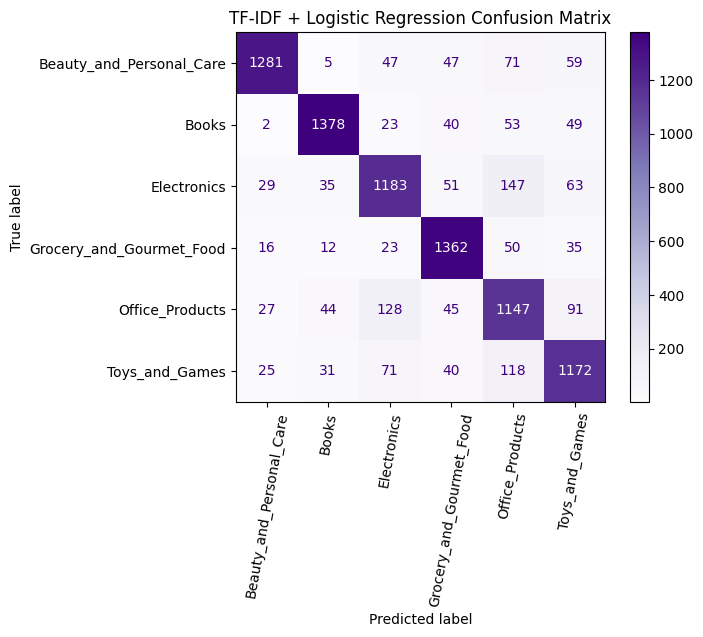

In [2]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(stop_words="english", max_features=10000)

processed_texts = tfid.fit_transform(reviews["text"])

# Train-Test
from sklearn.model_selection import train_test_split

X = processed_texts
y = reviews["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

# Fit regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class="multinomial", solver="saga",
                           penalty="elasticnet", l1_ratio=0.5, C=1)

model.fit(X_train, y_train)
y_test_df = pd.DataFrame()
y_test_df["true_value"] = y_test

y_test_df["logistic_regression"] = model.predict(X_test)

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
cm = confusion_matrix(y_true=y_test_df["true_value"],
                      y_pred=y_test_df["logistic_regression"],
                      labels=np.unique(y_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=np.unique(y_test))
disp.plot(cmap="Purples", xticks_rotation=80)

import matplotlib.pyplot as plt
plt.title("TF-IDF + Logistic Regression Confusion Matrix")


# Accuracy
accuracy_df = pd.DataFrame(columns=["model", "set", "accuracy"])


# Train Accuracy to check overfitting
y_train_pred = model.predict(X_train)
accuracy_train = accuracy_score(y_pred=y_train_pred, y_true=y_train)
print(f"Accuracy of Train Set: {accuracy_train:.2f}")

# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"], 
                          y_pred=y_test_df["logistic_regression"])
print(f"Accuracy of Logistic Regression Model: {accuracy:.2f}")


new_data = pd.DataFrame([
                        {"model": "tf_idf_logistic_regression", "set": "train", "accuracy": accuracy_train},
                         {"model": "tf_idf_logistic_regression", "set": "test", "accuracy": accuracy}
                         ])

accuracy_df = pd.concat([accuracy_df, new_data], axis=0, ignore_index=True)


### False Positive for each category:

Text(0, 0.5, 'Category')

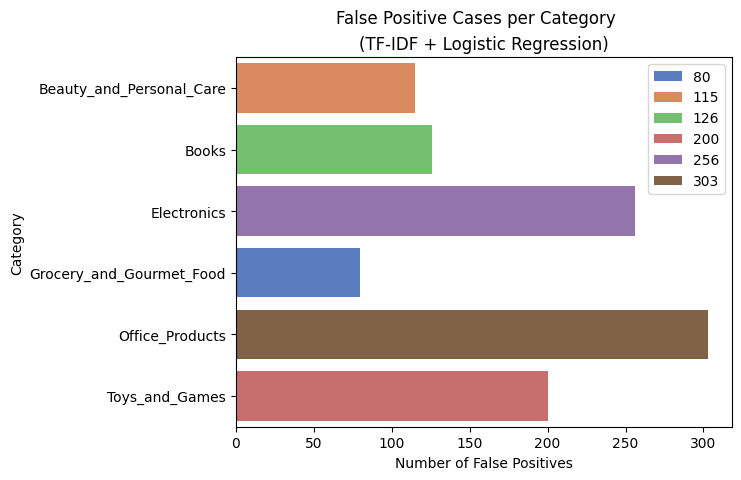

In [ ]:
false_positives = np.sum(cm, axis=0) - np.diag(cm)

import seaborn as sns
sns.barplot(y=np.unique(y_test).tolist(),
            x=false_positives, 
            hue=false_positives,
            palette="muted")

plt.suptitle("False Positive Cases per Category")
plt.title("(TF-IDF + Logistic Regression)")
plt.xlabel("Number of False Positives")
plt.ylabel("Category")
plt.legend([],[], frameon=False)



We see that Office_Products, Electronics, and Toys_and_Games have been mistakenly assigned to reviews the most.

# STEP 1.2: TF-IDF + Random Forest

Accuracy of Train Set: 0.86
Accuracy of Random Forest Model: 0.79


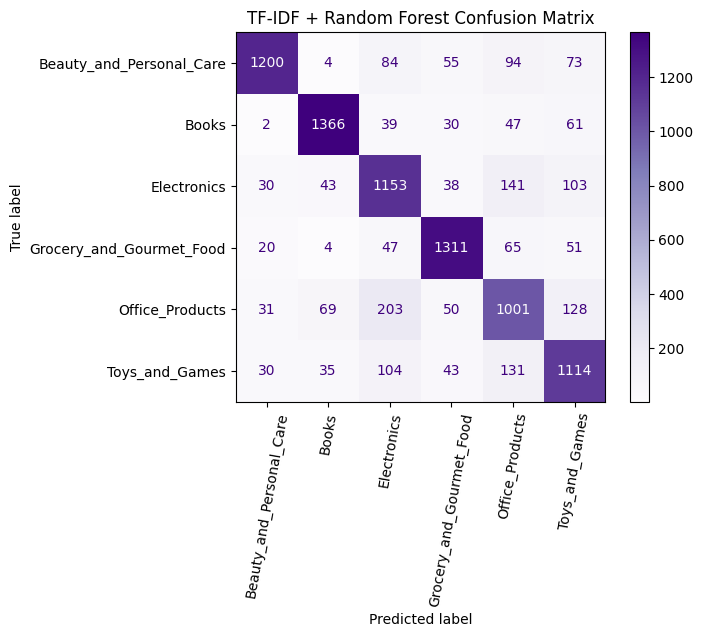

In [31]:
# Fit random forest Model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(min_samples_leaf=3,
                                  min_samples_split=10)
rf_model.fit(X_train, y_train)

y_test_df["random_forest"] = rf_model.predict(X_test)

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=y_test_df["true_value"],
                      y_pred=y_test_df["random_forest"],
                      labels=np.unique(y_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.unique(y_test))
disp.plot(cmap="Purples", xticks_rotation=80)


import matplotlib.pyplot as plt
plt.title("TF-IDF + Random Forest Confusion Matrix")


# Accuracy

# Train Accuracy to check overfitting
y_train_pred = rf_model.predict(X_train)
accuracy_train = accuracy_score(y_pred=y_train_pred, y_true=y_train)
print(f"Accuracy of Train Set: {accuracy_train:.2f}")

# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"], 
                          y_pred=y_test_df["random_forest"])
print(f"Accuracy of Random Forest Model: {accuracy:.2f}")


new_data = pd.DataFrame([
                        {"model": "tf_idf_random_forest", "set": "train", "accuracy": accuracy_train},
                         {"model": "tf_idf_random_forest", "set": "test", "accuracy": accuracy}])

accuracy_df = pd.concat([accuracy_df, new_data], axis=0, ignore_index=True)


## False Positive Cases 

Text(0, 0.5, 'Category')

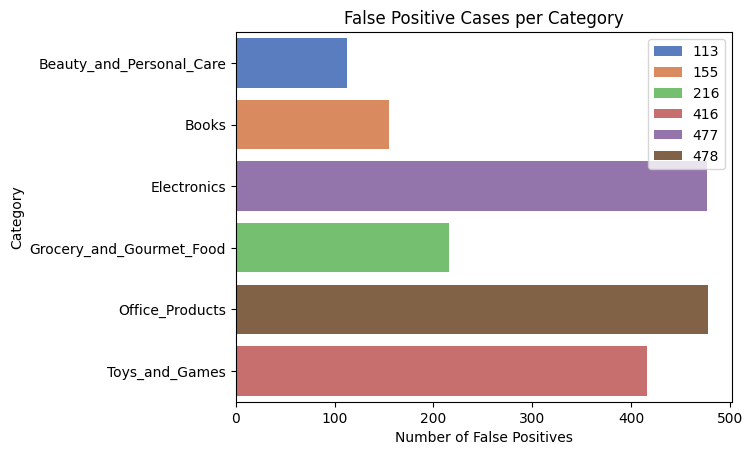

In [ ]:
false_positives = np.sum(cm, axis=0) - np.diag(cm)

import seaborn as sns
sns.barplot(y=np.unique(y_test).tolist(),
            x=false_positives, 
            hue=false_positives,
            palette="muted")

plt.suptitle("False Positive Cases per Category")
plt.title("(TF-IDF + Random Forest Model)")
plt.xlabel("Number of False Positives")
plt.ylabel("Category")
plt.legend([],[], frameon=False)



In [82]:
from sklearn.model_selection import train_test_split

X = reviews["text"]
y = reviews["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

# STEP 2.1: Zero Shot Classification

In [7]:
#model="facebook/bart-large-mnli",

# Using batch

from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli", 
                      device=1)
def llm_classifier_batch(texts, batch_size=16):
    labels = [
        "Beauty_and_Personal_Care",
        "Books",
        "Electronics",
        "Grocery_and_Gourmet_Food",
        "Toys_and_Games",
        "Office_Products"
    ]

    texts = texts.to_list()
    results = []
    scores = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_results = list(classifier(batch, candidate_labels=labels, multi_label=True))

        # Extract top predicted labels
        batch_labels = [res["labels"][0] for res in batch_results]
        batch_scores = [res["scores"][0] for res in batch_results]
        results.extend(batch_labels)
        scores.extend(batch_scores)

    return results, scores

# Run batch processing
y_pred_0_shot, y_pred_0_shot_scores = llm_classifier_batch(X_test, batch_size=16)


y_test_df["zero_classification"] = y_pred_0_shot


# Metrics
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true=y_test_df["true_value"],
                          y_pred=y_test_df["zero_classification"])

print(f"Accuracy of Zero-Classification Model:{accuracy:.2f}")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=y_test_df["true_value"],
                      y_pred=y_test_df["zero_classification"],
                      labels=np.unique(y_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.unique(y_test))
disp.plot(cmap="Purples", xticks_rotation=80)


import matplotlib.pyplot as plt
plt.title("Zero-classification Confusion Matrix")


# STEP 2.2: Fine Tune LLM Model "distilbert-base-uncased"

In [34]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset

df_train = pd.DataFrame({"text": X_train, "label": y_train})
df_test = pd.DataFrame({"text": X_test, "label": y_test})

# Convert labels to numerical values
label_map = {label: idx for idx, label in enumerate(y_train.unique())}

df_train["label"] = df_train["label"].map(label_map)
df_test["label"] = df_test["label"].map(label_map)


# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)


model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


# Tokenize data
train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)


# Remove unnecessary columns
train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text", "__index_level_0__"])
test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text", "__index_level_0__"])

# Convert labels to tensor format
train_dataset_tokenized = train_dataset_tokenized.with_format("torch")
test_dataset_tokenized = test_dataset_tokenized.with_format("torch")


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)



#Train
from transformers import Trainer, TrainingArguments


training_args = TrainingArguments(
                    output_dir="./results",
                    evaluation_strategy="epoch",
                    learning_rate=3e-5,
                    per_device_train_batch_size=16,
                    per_device_eval_batch_size=16,
                    num_train_epochs=3,
                    weight_decay=0.02,
                    gradient_accumulation_steps=1,
                    warmup_steps=int(0.1 * (len(X_train) // 16) * 5),
                    logging_steps=500
                )




trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized
)

# Train the model
trainer.train()

# Prediction and evaluation
predictions = trainer.predict(test_dataset_tokenized)

# Convert logits to predicted labels
y_pred_finetuned = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()



/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 9000/9000 [00:01<00:00, 6021.35 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, a

Epoch,Training Loss,Validation Loss
1,No log,0.443657
2,0.931100,0.381312
3,0.367700,0.374289


/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Train set Accuracy:0.95
Accuracy of Finetuned Bert LLM: 0.88


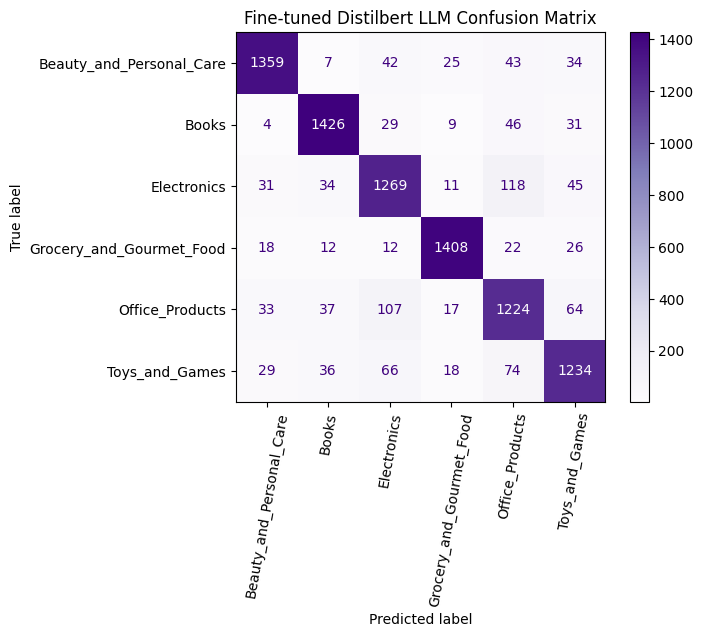

In [35]:
# Convert the labels back to category names
label_map_reverse = {v: k for k, v in label_map.items()}
y_test_df
y_test_df["finetuned_bert"] = [label_map_reverse[label] for label in y_pred_finetuned]

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


train_predictions = trainer.predict(train_dataset_tokenized)
y_pred_finetuned_train = torch.argmax(torch.tensor(train_predictions.predictions), dim=1).numpy()
label_map_reverse = {v: k for k, v in label_map.items()}
y_pred_finetuned_train_num= [label_map_reverse[label] for label in y_pred_finetuned_train]

# Train Accuracy
train_accuracy =  accuracy_score(y_true=y_train,
                        y_pred=y_pred_finetuned_train_num)
print(f"Train set Accuracy:{train_accuracy:.2f}")


# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"],
                          y_pred=y_test_df["finetuned_bert"])
print(f"Accuracy of Finetuned Bert LLM: {accuracy:.2f}")


# Confusion Matrix
cm = confusion_matrix(y_true=y_test_df["true_value"],
                      y_pred=y_test_df["finetuned_bert"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.unique(y_test))
disp.plot(cmap="Purples", xticks_rotation=80)


import matplotlib.pyplot as plt
plt.title("Fine-tuned Distilbert LLM Confusion Matrix")


new_data = pd.DataFrame([
                        {"model": "fine_tuned_distilbert_LLM", "set": "train", "accuracy": accuracy_train},
                         {"model": "fine_tuned_distilbert_LLM", "set": "test", "accuracy": accuracy}])

accuracy_df = pd.concat([accuracy_df, new_data], axis=0, ignore_index=True)

### False Positive Case

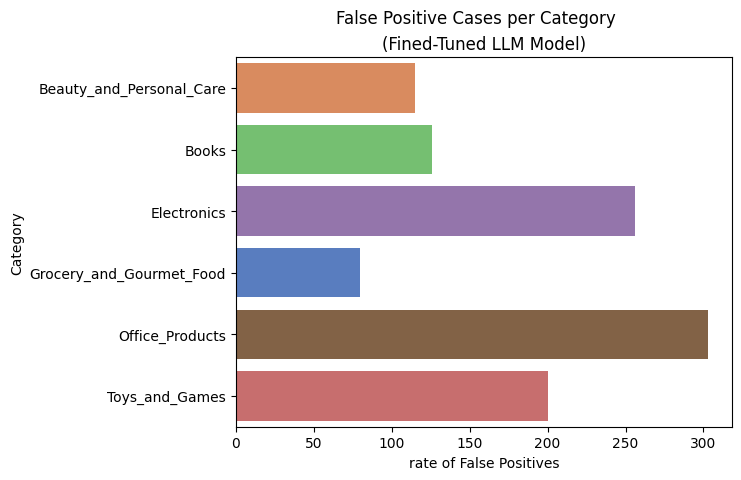

In [ ]:
false_positives = np.sum(cm, axis=0) - np.diag(cm)

import seaborn as sns
sns.barplot(y=np.unique(y_test).tolist(),
            x=false_positives, 
            hue=false_positives,
            palette="muted")

plt.suptitle("False Positive Cases per Category")
plt.title("(Fined-Tuned LLM Model)")
plt.xlabel("rate of False Positives")
plt.ylabel("Category")
plt.legend([],[], frameon=False)

In [57]:
results_df = pd.DataFrame({"text": X_test})
results_df = pd.concat([results_df, y_test_df], axis=1)

for model in ["logistic_regression", "random_forest", "finetuned_bert"]:
    results_df[f"{model}_misclassified"] = results_df["true_value"] != results_df[model]


In [ ]:
results_df["zero_shot_scores"] = y_pred_0_shot_scores
results_df["logistic_regression_misclassified"]

# STEP 3: Error Analysis

Analyze Misclassification by Length in fine-tuned model:


Text(0, 0.5, 'Length')

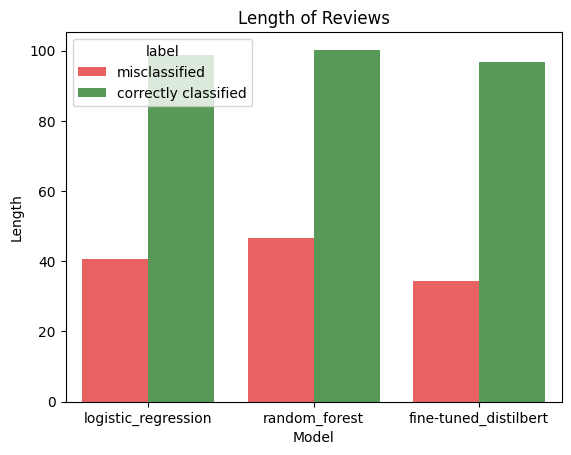

In [60]:
counts_df = pd.DataFrame(columns=["model", "misclassified", "correctly classified"])

def count_words(examples):
    return len(examples.split())

a = reviews["text"].apply(count_words).mean()



# Logistic Regression
b = results_df.loc[results_df["logistic_regression_misclassified"], "text"].apply(count_words).mean()
c = results_df.loc[~results_df["logistic_regression_misclassified"], "text"].apply(count_words).mean()

new_counts = pd.DataFrame([{"model": "logistic_regression",
                          "misclassified": b,
                          "correctly classified": c}])

counts_df = pd.concat([counts_df, new_counts], axis=0, ignore_index=True)



# Random Forest
b = results_df.loc[results_df["random_forest_misclassified"], "text"].apply(count_words).mean()
c = results_df.loc[~results_df["random_forest_misclassified"], "text"].apply(count_words).mean()

new_counts = pd.DataFrame([{"model": "random_forest",
                          "misclassified": b,
                          "correctly classified": c}])

counts_df = pd.concat([counts_df, new_counts], axis=0, ignore_index=True)

'''
# Zero Classification
b = results_df.loc[results_df["zero_classification_misclassified"], "text"].apply(count_words).mean()
c = results_df.loc[~results_df["zero_classification_misclassified"], "text"].apply(count_words).mean()


new_counts = pd.DataFrame([{"model": "zero_classification",
                          "misclassified": b,
                          "correctly classified": c}])

counts_df = pd.concat([counts_df, new_counts], axis=0, ignore_index=True)

'''


# Fined-tuned model
b = results_df.loc[results_df["finetuned_bert_misclassified"], "text"].apply(count_words).mean()
c = results_df.loc[~results_df["finetuned_bert_misclassified"], "text"].apply(count_words).mean()


new_counts = pd.DataFrame([{"model": "fine-tuned_distilbert",
                          "misclassified": b,
                          "correctly classified": c}])

counts_df = pd.concat([counts_df, new_counts], axis=0, ignore_index=True)


counts_df

counts_df_melt = counts_df.melt(id_vars="model", var_name="label", value_name="length")
sns.barplot(data=counts_df_melt,
            x="model",
            y="length",
            hue="label",
            palette=["red", "green"],
            alpha=0.7)


plt.title("Length of Reviews")

plt.xlabel("Model")
plt.ylabel("Length")

We can see that definitly the length of the review can have effect on probability of misclassification

In [151]:
pd.set_option('display.max_colwidth', None)


## STEP 3.2: undersample longer reviews for the train set

In [ ]:
from sklearn.model_selection import train_test_split

X = reviews["text"]
y = reviews["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [86]:
X_train_with_length = pd.DataFrame({"X_train":X_train,
                      "length": [count_words(x) for x in X_train]})

X_train_short_reviews = X_train_with_length[X_train_with_length["length"] < 40]
X_train_long_reviews = X_train_with_length[X_train_with_length["length"] >= 40]

X_train_long_undersampled = X_train_long_reviews.sample(frac=0.7, random_state=22, replace=False)

X_train_undersampled = pd.concat([X_train_long_undersampled, X_train_short_reviews], axis=0)["X_train"]

In [ ]:
# TF-IDF with logistic regression
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(stop_words="english", max_features=10000)

processed_texts = tfid.fit_transform(reviews["text"])

# Train-Test
from sklearn.model_selection import train_test_split

X = processed_texts
y = reviews["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

##### Undersample
X_train = X[X_train_undersampled.index]
y_train = y[X_train_undersampled.index]
#####

# Fit regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class="multinomial", solver="saga",
                           penalty="elasticnet", l1_ratio=0.5, C=1)

model.fit(X_train, y_train)

y_test_df["logistic_regression_undersampled"] = model.predict(X_test)


# Accuracy

# Train Accuracy to check overfitting
y_train_pred = model.predict(X_train)

accuracy_train = accuracy_score(y_pred=y_train_pred, y_true=y_train)

# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"], 
                          y_pred=y_test_df["logistic_regression"])


new_data = pd.DataFrame([
                        {"model": "tf_idf_logistic_undersampled", "set": "train", "accuracy": accuracy_train},
                         {"model": "tf_idf_logistic_undersampled", "set": "test", "accuracy": accuracy}])

accuracy_df = pd.concat([accuracy_df, new_data], axis=0, ignore_index=True)

In [88]:
# TF-IDF fit random forest Model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(min_samples_leaf=3,
                                  min_samples_split=10)
rf_model.fit(X_train, y_train)

y_test_df["random_forest"] = rf_model.predict(X_test)



# Accuracy

# Train Accuracy to check overfitting
y_train_pred = rf_model.predict(X_train)

accuracy_train = accuracy_score(y_pred=y_train_pred, y_true=y_train)

# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"], 
                          y_pred=y_test_df["random_forest"])


new_data = pd.DataFrame([
                        {"model": "tf_idf_random_forest_undersampled", "set": "train", "accuracy": accuracy_train},
                         {"model": "tf_idf_random_forest_undersampled", "set": "test", "accuracy": accuracy}])

accuracy_df = pd.concat([accuracy_df, new_data], axis=0, ignore_index=True)


In [90]:
# Fine-tuned distilbert undersampled

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split

#### Undersample
X = reviews["text"]
y = reviews["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

X_train = X_train_undersampled
y_train = y_train.loc[X_train_undersampled.index]
#### Undersample

df_train = pd.DataFrame({"text": X_train, "label": y_train})
df_test = pd.DataFrame({"text": X_test, "label": y_test})

# Convert labels to numerical values
label_map = {label: idx for idx, label in enumerate(y_train.unique())}

df_train["label"] = df_train["label"].map(label_map)
df_test["label"] = df_test["label"].map(label_map)


# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)


model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


# Tokenize data
train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)


# Remove unnecessary columns
train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text", "__index_level_0__"])
test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text", "__index_level_0__"])

# Convert labels to tensor format
train_dataset_tokenized = train_dataset_tokenized.with_format("torch")
test_dataset_tokenized = test_dataset_tokenized.with_format("torch")


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)



#Train
from transformers import Trainer, TrainingArguments


training_args = TrainingArguments(
                    output_dir="./results",
                    evaluation_strategy="epoch",
                    learning_rate=3e-5,
                    per_device_train_batch_size=16,
                    per_device_eval_batch_size=16,
                    num_train_epochs=3,
                    weight_decay=0.02,
                    gradient_accumulation_steps=1,
                    warmup_steps=int(0.1 * (len(X_train) // 16) * 5),
                    logging_steps=500
                )




trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized
)

# Train the model
trainer.train()

# Prediction and evaluation
predictions = trainer.predict(test_dataset_tokenized)

# Convert logits to predicted labels
y_pred_finetuned = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()



Map: 100%|██████████| 9000/9000 [00:01<00:00, 5774.96 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/

Epoch,Training Loss,Validation Loss
1,No log,0.461467
2,0.969200,0.400797
3,0.368900,0.385046


/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [91]:
# Convert the labels back to category names
label_map_reverse = {v: k for k, v in label_map.items()}
y_test_df
y_test_df["finetuned_bert"] = [label_map_reverse[label] for label in y_pred_finetuned]

# Metrics
from sklearn.metrics import accuracy_score


train_predictions = trainer.predict(train_dataset_tokenized)
y_pred_finetuned_train = torch.argmax(torch.tensor(train_predictions.predictions), dim=1).numpy()
label_map_reverse = {v: k for k, v in label_map.items()}
y_pred_finetuned_train_num= [label_map_reverse[label] for label in y_pred_finetuned_train]

# Train Accuracy
train_accuracy =  accuracy_score(y_true=y_train,
                        y_pred=y_pred_finetuned_train_num)


# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"],
                          y_pred=y_test_df["finetuned_bert"])



new_data = pd.DataFrame([
                        {"model": "fine_tuned_distilbert_LLM_undersampled", "set": "train", "accuracy": accuracy_train},
                         {"model": "fine_tuned_distilbert_LLM_undersampled", "set": "test", "accuracy": accuracy}])

accuracy_df = pd.concat([accuracy_df, new_data], axis=0, ignore_index=True)

In [92]:
accuracy_df["accuracy"] = accuracy_df["accuracy"].round(2)
accuracy_df

,model,set,accuracy
0,tf_idf_logistic_regression,train,0.87
1,tf_idf_logistic_regression,test,0.84
2,tf_idf_random_forest,train,0.86
3,tf_idf_random_forest,test,0.79
4,tf_idf_random_forest,train,0.86
5,tf_idf_random_forest,test,0.79
6,fine_tuned_distilbert_LLM,train,0.86
7,fine_tuned_distilbert_LLM,test,0.88
8,tf_idf_logistic_undersampled,train,0.86
9,tf_idf_logistic_undersampled,test,0.84


undersampling from the long reviews did not increase the accuracy much. But it did decrease the overfitting.

## STEP 3.2: Compare Errors by Category

In [93]:
misclassified_categories = results_df.groupby("true_value", as_index=False)[["logistic_regression_misclassified", "random_forest_misclassified", "finetuned_bert_misclassified"]].sum().sort_values("logistic_regression_misclassified")
misclassified_categories

,true_value,logistic_regression_misclassified,random_forest_misclassified,finetuned_bert_misclassified
3,Grocery_and_Gourmet_Food,136,187,90
1,Books,167,179,119
0,Beauty_and_Personal_Care,229,310,151
5,Toys_and_Games,285,343,223
2,Electronics,325,355,239
4,Office_Products,335,481,258


Text(0.5, 0, 'Misclassified Count')

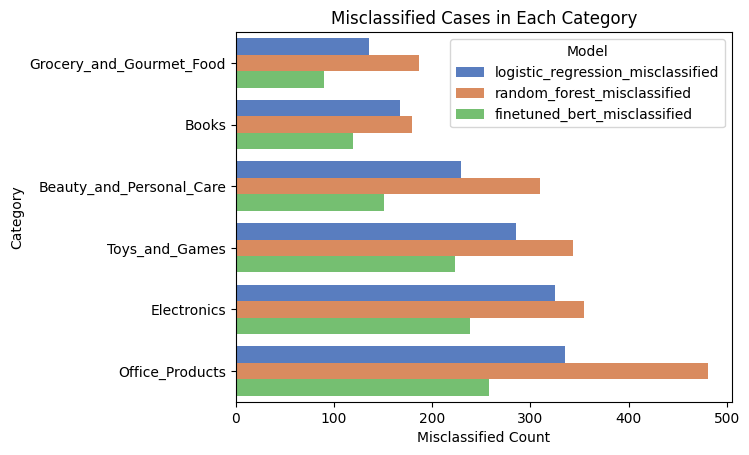

In [94]:
misclassified_melted = misclassified_categories.melt(id_vars="true_value", var_name="Model", value_name="Misclassified Count")

import seaborn as sns
sns.barplot(data=misclassified_melted,
            y="true_value",
            x="Misclassified Count",
            hue="Model",
            palette="muted")

plt.title("Misclassified Cases in Each Category")
plt.ylabel("Category")
plt.xlabel("Misclassified Count")


"Office_Products" and "Electronics" have the largest misclassified cases in all the models.

Seems like the Zero-Classification Model was more confident on classifying cases incorrect than correct.  <br>
Also most of the misclassified cases were classified as the "Office_Products".


- Looks like overal categories "Office_Products" and "Electronics" have the most misclassifications. <br>
- Also in Zero shot classification, "Toys_and_Games" and "Beauty_and_Personal_care" have over 50% of the samples misclassified.

Let's dig into it:

For Office_Products and Electronics, first we will look at the cases which were misclassified in all the models.

## STEP 3.3: Compare model agreement

### Which cases have been misclassified in every model?

In [95]:
pd.set_option('display.max_colwidth', None)

'''
boolean_columns = ["logistic_regression_misclassified", 
                   "random_forest_misclassified", 
                   "zero_classification_misclassified", 
                   "finetuned_bert_misclassified"]'
'''
boolean_columns = ["logistic_regression_misclassified", 
                   "random_forest_misclassified", 
                   "finetuned_bert_misclassified"]

# indices of all the cases that have been misclassified in every model
bool_series = results_df[boolean_columns].all(axis=1)
idx_always_misclassified = bool_series[bool_series].index
always_misclassified = results_df.loc[idx_always_misclassified, "text"]

### Which words repeated the most in always misclassified cases?

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english")
X_tfidf = tfidf.fit_transform(always_misclassified)

# Get feature names (words)
words = tfidf.get_feature_names_out()

# Sum up the TF-IDF scores for each word
word_tfidf_scores = X_tfidf.sum(axis=0).A1 

always_misclassified_word_frequency = pd.DataFrame({"word": words,
                                                    "score": word_tfidf_scores})

always_misclassified_word_frequency.sort_values("score", ascending=False).head(30)


,word,score
1310,good,32.985753
2371,product,30.235429
1347,great,29.247075
2374,productgood,26.573636
1801,love,18.832649
394,br,12.639408
2437,quality,12.540784
3359,use,12.437160
1741,like,11.930935
1284,gift,11.241901


Mostly too general words!

### Word Cloud for always misclassified cases

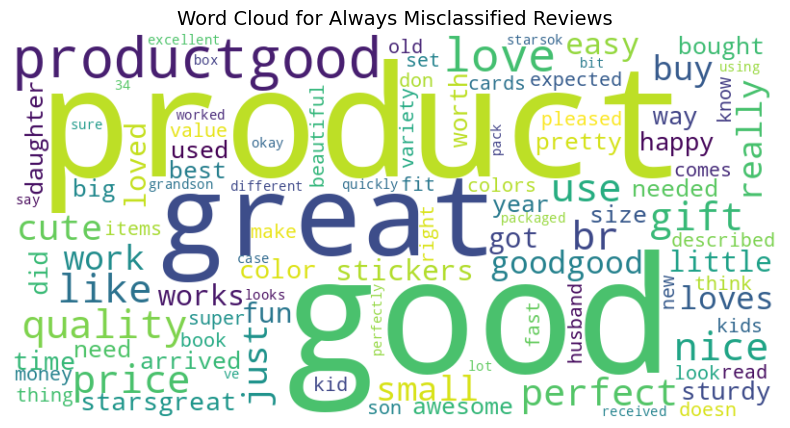

In [103]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df has two columns: 'word' and 'score'
word_score_data = dict(zip(always_misclassified_word_frequency["word"], always_misclassified_word_frequency["score"]))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis",
                      max_words=100).generate_from_frequencies(word_score_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Word Cloud for Always Misclassified Reviews", fontsize=14)
plt.show()


In [38]:
np.mean([count_words(x) for x in results_df.loc[idx_always_misclassified, "text"]])


32.46984572230014

The average length of the reviews which were always misclassified is lower that the average length of all the reviews. 

Looking at the cases that have been misclassified by all the models, these are mainly reviews that are too general and do not specifically mention anything related to the product. They are often short reviews stating that the product was nice, good, bad, or broken without providing any further context. As a result, the models tend to randomly assign a category to them. <br>

We can remove the reviews that were consistently misclassified by every model, as these cases tend to be too broad, too short, or lack specific references to the product.

In [108]:
reviews_dropped_general = reviews.drop(idx_always_misclassified, axis=0)

In [114]:
# TF-IDF logistic regression
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(stop_words="english", max_features=10000)

processed_texts = tfid.fit_transform(reviews_dropped_general["text"])

# Train-Test
from sklearn.model_selection import train_test_split

X = processed_texts
y = reviews_dropped_general["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

# Fit regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class="multinomial", solver="saga",
                           penalty="elasticnet", l1_ratio=0.5, C=1)

model.fit(X_train, y_train)
y_test_df = pd.DataFrame()
y_test_df["true_value"] = y_test

y_test_df["logistic_regression"] = model.predict(X_test)

# Metrics
# Accuracy
accuracy_df_dropped_general = pd.DataFrame(columns=["model", "set", "accuracy"])


# Train Accuracy to check overfitting
y_train_pred = model.predict(X_train)
accuracy_train = accuracy_score(y_pred=y_train_pred, y_true=y_train)


# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"], 
                          y_pred=y_test_df["logistic_regression"])



new_data = pd.DataFrame([
                        {"model": "tf_idf_logistic_regression", "set": "train", "accuracy": accuracy_train},
                         {"model": "tf_idf_logistic_regression", "set": "test", "accuracy": accuracy}
                         ])

accuracy_df_dropped_general = pd.concat([accuracy_df_dropped_general, new_data], axis=0, ignore_index=True)


In [115]:
# Fine-tuned distilbert 

from sklearn.model_selection import train_test_split

X = reviews_dropped_general["text"]
y = reviews_dropped_general["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)



from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split


df_train = pd.DataFrame({"text": X_train, "label": y_train})
df_test = pd.DataFrame({"text": X_test, "label": y_test})

# Convert labels to numerical values
label_map = {label: idx for idx, label in enumerate(y_train.unique())}

df_train["label"] = df_train["label"].map(label_map)
df_test["label"] = df_test["label"].map(label_map)


# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)


model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


# Tokenize data
train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)


# Remove unnecessary columns
train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text", "__index_level_0__"])
test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text", "__index_level_0__"])

# Convert labels to tensor format
train_dataset_tokenized = train_dataset_tokenized.with_format("torch")
test_dataset_tokenized = test_dataset_tokenized.with_format("torch")


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)



#Train
from transformers import Trainer, TrainingArguments


training_args = TrainingArguments(
                    output_dir="./results",
                    evaluation_strategy="epoch",
                    learning_rate=3e-5,
                    per_device_train_batch_size=16,
                    per_device_eval_batch_size=16,
                    num_train_epochs=3,
                    weight_decay=0.02,
                    gradient_accumulation_steps=1,
                    warmup_steps=int(0.1 * (len(X_train) // 16) * 5),
                    logging_steps=500
                )




trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized
)

# Train the model
trainer.train()

# Prediction and evaluation
predictions = trainer.predict(test_dataset_tokenized)

# Convert logits to predicted labels
y_pred_finetuned = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()


# Convert the labels back to category names
label_map_reverse = {v: k for k, v in label_map.items()}
y_test_df
y_test_df["finetuned_bert"] = [label_map_reverse[label] for label in y_pred_finetuned]

# Metrics
from sklearn.metrics import accuracy_score


train_predictions = trainer.predict(train_dataset_tokenized)
y_pred_finetuned_train = torch.argmax(torch.tensor(train_predictions.predictions), dim=1).numpy()
label_map_reverse = {v: k for k, v in label_map.items()}
y_pred_finetuned_train_num= [label_map_reverse[label] for label in y_pred_finetuned_train]

# Train Accuracy
train_accuracy =  accuracy_score(y_true=y_train,
                        y_pred=y_pred_finetuned_train_num)


# Test Accuracy
accuracy = accuracy_score(y_true=y_test_df["true_value"],
                          y_pred=y_test_df["finetuned_bert"])



new_data = pd.DataFrame([
                        {"model": "fine_tuned_distilbert_LLM_undersampled", "set": "train", "accuracy": accuracy_train},
                         {"model": "fine_tuned_distilbert_LLM_undersampled", "set": "test", "accuracy": accuracy}])

accuracy_df_dropped_general = pd.concat([accuracy_df_dropped_general, new_data], axis=0, ignore_index=True)



Map: 100%|██████████| 8784/8784 [00:01<00:00, 5780.65 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/

Epoch,Training Loss,Validation Loss
1,No log,0.411864
2,0.894100,0.338946
3,0.298000,0.337157


/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [116]:
accuracy_df_dropped_general

,model,set,accuracy
0,tf_idf_logistic_regression,train,0.892857
1,tf_idf_logistic_regression,test,0.846995
2,fine_tuned_distilbert_LLM_undersampled,train,0.892857
3,fine_tuned_distilbert_LLM_undersampled,test,0.893556


The TFIDF logistic regression model did not change much by removing the vague reviews but the LLM model improved both in train and test dataset.

### What are the average confidence scores of zero-shot classification in both successful and unsuccessful classifications?

In [ ]:
results_df.groupby("zero_classification_misclassified")["zero_shot_scores"].mean()

zero_classification_misclassified
False    0.667724
True     0.518112
Name: zero_shot_scores, dtype: float64

In [ ]:
pd.reset_option('display.max_colwidth')


In [119]:
reviews["category"].unique()

array(['Beauty_and_Personal_Care', 'Office_Products',
       'Grocery_and_Gourmet_Food', 'Books', 'Toys_and_Games',
       'Electronics'], dtype=object)

## Looking into Electronics category, Office_Products category and Grocery_and_Gourmet_Food category

Among all categories, Electronics and Office_Products have the highest number of false positive cases, while Grocery_and_Gourmet_Food consistently shows low false positives. This contrast makes them a good set for comparison when visualizing how mixed the categories appear after PCA transformation.

In [2]:
office_electronics = reviews[reviews["category"].isin(["Electronics", "Office_Products", "Grocery_and_Gourmet_Food"])]
office_electronics.head()

,text,category
1,"Sturdy!These are sturdy, poly plastic folder/d...",Office_Products
3,"Great value, big box.This 58 count box is such...",Grocery_and_Gourmet_Food
6,Simply HeinzI didn't realize that I could stil...,Grocery_and_Gourmet_Food
9,Decadently wonderful Caramel!Walkers makes sup...,Grocery_and_Gourmet_Food
10,Big cupsVery good,Grocery_and_Gourmet_Food


## PCA for TF-IDF features

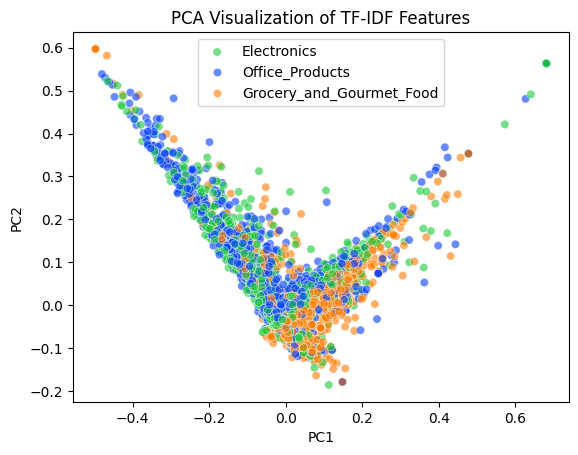

In [12]:
from sklearn.model_selection import train_test_split
X = office_electronics["text"]
y = office_electronics["category"]



# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(stop_words="english", max_features=10000)
processed_X = tfid.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(processed_X.toarray(), y, test_size=0.3, random_state=22)


# Convert labels to numeric 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)


# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=5)

X_pca = pca.fit_transform(X=X_train)


pca_df = pd.DataFrame({"PC1": X_pca[:, 0],
                       "PC2": X_pca[:, 1],
                       "label": y_train_num})

import seaborn as sns
sns.scatterplot(x=pca_df["PC1"], y=pca_df["PC2"],
                hue=pca_df["label"], alpha=0.6, palette="bright")

plt.title("PCA Visualization of TF-IDF Features")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(["Electronics", "Office_Products", "Grocery_and_Gourmet_Food"])

The plot above doesn't show any separation between two categories using PCs. Let's try the embedding of our LLM model too.

## PCA for fine-tuned LLM embeddings

In [3]:
from sklearn.model_selection import train_test_split

X = office_electronics["text"]
y = office_electronics["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

# **** TRAINING PART - START ****

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split


df_train = pd.DataFrame({"text": X_train, "label": y_train})
df_test = pd.DataFrame({"text": X_test, "label": y_test})

# Convert labels to numerical values
label_map = {label: idx for idx, label in enumerate(y_train.unique())}

df_train["label"] = df_train["label"].map(label_map)
df_test["label"] = df_test["label"].map(label_map)


# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)


model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


# Tokenize data
train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)


# Remove unnecessary columns
train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text", "__index_level_0__"])
test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text", "__index_level_0__"])

# Convert labels to tensor format
train_dataset_tokenized = train_dataset_tokenized.with_format("torch")
test_dataset_tokenized = test_dataset_tokenized.with_format("torch")


model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()



#Train
from transformers import Trainer, TrainingArguments


training_args = TrainingArguments(
                    output_dir="./results",
                    evaluation_strategy="epoch",
                    learning_rate=3e-5,
                    per_device_train_batch_size=16,
                    per_device_eval_batch_size=16,
                    num_train_epochs=3,
                    weight_decay=0.02,
                    gradient_accumulation_steps=1,
                    warmup_steps=int(0.1 * (len(X_train) // 16) * 5),
                    logging_steps=500
                )




trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized
)

# Train the model
trainer.train()
# **** TRAINING PART - END****

# Save Model
trainer.save_model("finetuned_model/")



/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 4500/4500 [00:00<00:00, 6012.36 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, a

RuntimeError: Caught RuntimeError in replica 1 on device 1.
Original Traceback (most recent call last):
  File "/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 84, in _worker
    output = module(*input, **kwargs)
  File "/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/transformers/models/distilbert/modeling_distilbert.py", line 989, in forward
    pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
  File "/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/mi130176/STA 6908/myenv/lib/python3.8/site-packages/torch/nn/modules/linear.py", line 117, in forward
    return F.linear(input, self.weight, self.bias)
RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling cublasLtMatmul with transpose_mat1 1 transpose_mat2 0 m 768 n 16 k 768 mat1_ld 768 mat2_ld 393216 result_ld 768 abcType 0 computeType 68 scaleType 0


In [4]:
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = AutoModel.from_pretrained("finetuned_model/").to(device)
embedding_model.eval()

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

# Batching
batch_size = 32
all_embeddings = []

for i in range(0, len(X_train), batch_size):
    batch_texts = list(X_train[i:i+batch_size])
    inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = embedding_model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(cls_embeddings)

# Combine batches into full array
train_embeddings = np.vstack(all_embeddings)
print("Embedding shape:", train_embeddings.shape)


Embedding shape: (7000, 768)


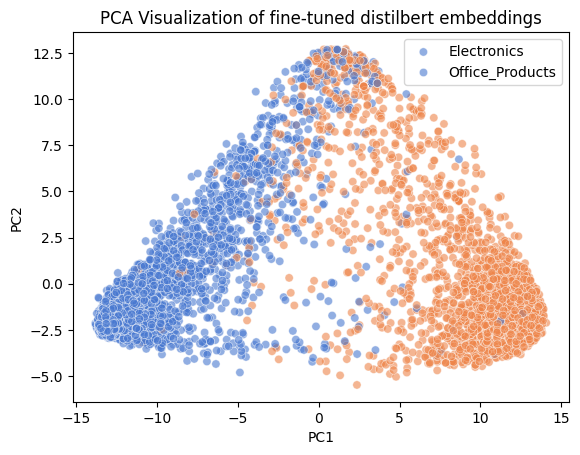

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_embeddings)

pca_df = pd.DataFrame({"PC1": X_pca[:, 0],
                       "PC2": X_pca[:, 1],
                       "label": y_train})


import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(x="PC1", y="PC2", data=pca_df,
                hue="label", palette="bright", alpha=0.6)

plt.title("PCA Visualization of fine-tuned distilbert embeddings")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(['Electronics', 'Office_Products'])